# Binary classifier using esm2 embeddings
----

In [1]:
import optuna
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import h5py
import time

import os
from dotenv import load_dotenv
load_dotenv()

from data_manipulation.reading_util import load_ml_data_emb
from data_manipulation.reading_util import load_non_enz_esm2

2023-09-29 13:16:39.358661: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-29 13:16:39.520309: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-29 13:16:39.521392: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-29 13:16:40.445471: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
enzyme_csv_path = os.getenv("CSV70_ENZYMES")
esm2_enzymes_path = os.getenv("ESM2_ENZYMES_SPLIT_70")

non_enzymes_esm2_path = os.getenv("ESM2_NON_ENZYMES")
non_enzymes_fasta_path = os.getenv("FASTA_NON_ENZYMES")


# Load enzymes
X_enzymes, _ = load_ml_data_emb(path_to_esm2=esm2_enzymes_path, path_to_enzyme_csv=enzyme_csv_path)
del _ # delete unused ec_labels


# Load non_enzymes
X_non_enzymes, _ = load_non_enz_esm2(non_enzymes_fasta_path=non_enzymes_fasta_path, non_enzymes_esm2_path=non_enzymes_esm2_path)
del _ # delete unused labels which only fit for multi class classification

y_non_enzymes = np.array([0 for emb in range(len(X_non_enzymes))]) # Append label -1 for len(X_non_enzymes)
y_enzymes = np.array([1 for emb in range(len(X_enzymes))]) # Append label 1 for len(X_enzymes)

# Combine X_enzymes + X_non_enzymes; y_enzymes + y_non_enzymes
X = np.vstack((X_enzymes, X_non_enzymes))
y = np.hstack((y_enzymes, y_non_enzymes))

LOG: 4 Sequences with aa O in /home/malte/Desktop/Dataset/data/enzymes/csv/split70.csv
LOG: 66 Sequences with aa U in /home/malte/Desktop/Dataset/data/enzymes/csv/split70.csv
LOG: 1564 multifunctional enzymes with diff ec main classes in /home/malte/Desktop/Dataset/data/enzymes/csv/split70.csv
LOG: 1634 entries will be ignored
LOG: Data loaded in: 8.361 min
LOG: ESM2 of enzymes: 73553
LOG: Labels of enzymes: 73553
LOG: 0 Sequences with aa O in /home/malte/Desktop/Dataset/data/non_enzyme/fasta/no_enzyme_train.fasta
LOG: 17 Sequences with aa U in /home/malte/Desktop/Dataset/data/non_enzyme/fasta/no_enzyme_train.fasta
LOG: 2138 non enzymes are longer than 1022 cutoff
LOG: 2155 entries will be ignored
LOG: Non Enzymes data loaded in: 4.392 min
LOG: ESM2 of non enzymes: 39502
LOG: Labels of non enzymes: 39502


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Our labels need to be one hot encoded
# y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=2)
# y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=2)
# print(y_test_encoded[0])

In [9]:
# Initializing the model
model = tf.keras.models.Sequential()

earl_stop = tf.keras.callbacks.EarlyStopping(patience=9)

# Adding input layer
model.add(tf.keras.layers.Dense(units=256, activation='relu', input_shape=(2560,)))

# Adding hidden layer
model.add(tf.keras.layers.Dropout(0.5))  # Adding dropout for regularization
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))  # Adding dropout for regularization
model.add(tf.keras.layers.Dense(units=64, activation='relu'))

# Finally adding output layer using sigmoid as activation function
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))  # Using sigmoid

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam')

In [10]:
model.fit(x=X_train, y=y_train, epochs=50, validation_data=(X_test, y_test), callbacks = [earl_stop])

Epoch 1/50


2023-09-29 09:57:26.222831: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 810373120 exceeds 10% of free system memory.


2469/2474 [============================>.] - ETA: 0s - loss: 0.1899

2023-09-29 09:57:51.984754: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 347310080 exceeds 10% of free system memory.


2474/2474 [==============================] - 27s 11ms/step - loss: 0.1900 - val_loss: 0.1362
Epoch 2/50
2474/2474 [==============================] - 27s 11ms/step - loss: 0.1445 - val_loss: 0.1230
Epoch 3/50
2474/2474 [==============================] - 27s 11ms/step - loss: 0.1303 - val_loss: 0.1229
Epoch 4/50
2474/2474 [==============================] - 27s 11ms/step - loss: 0.1206 - val_loss: 0.1197
Epoch 5/50
2474/2474 [==============================] - 27s 11ms/step - loss: 0.1129 - val_loss: 0.1093
Epoch 6/50
2474/2474 [==============================] - 27s 11ms/step - loss: 0.1078 - val_loss: 0.1026
Epoch 7/50
2474/2474 [==============================] - 27s 11ms/step - loss: 0.1023 - val_loss: 0.1032
Epoch 8/50
2474/2474 [==============================] - 28s 11ms/step - loss: 0.0973 - val_loss: 0.1050
Epoch 9/50
2474/2474 [==============================] - 27s 11ms/step - loss: 0.0940 - val_loss: 0.0999
Epoch 10/50
2474/2474 [==============================] - 28s 11ms/step - lo

<Figure size 1000x600 with 0 Axes>

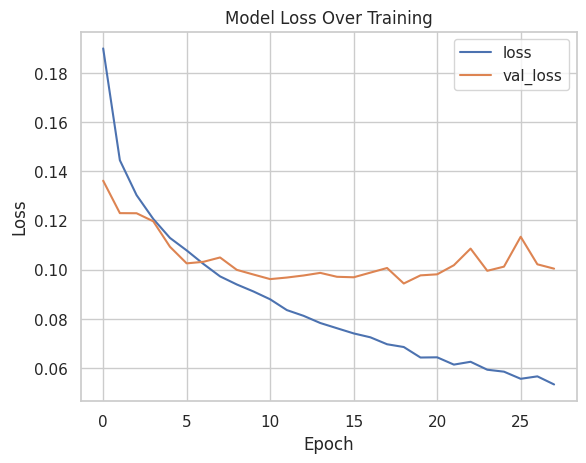

In [11]:
# Plotting loss (loss on train_data) and val_loss (loss on validation_data)
model_loss = pd.DataFrame(model.history.history)

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
model_loss.plot()

plt.title('Model Loss Over Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [12]:
predictions = (model.predict(X_test) > 0.5).astype(int) # binary classification

  44/1060 [>.............................] - ETA: 2s

2023-09-29 10:11:08.011973: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 347310080 exceeds 10% of free system memory.


1060/1060 [==============================] - 2s 2ms/step


In [13]:
counter = 0
for x,y in zip(y_test,predictions):
    if x == y:
        counter+=1
print("Correct predictions: ", counter)
print("Total samples predicted:", len(y_test))

Correct predictions:  32893
Total samples predicted: 33917


In [14]:
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.94      0.96     11695
           1       0.97      0.99      0.98     22222

    accuracy                           0.97     33917
   macro avg       0.97      0.96      0.97     33917
weighted avg       0.97      0.97      0.97     33917


In [5]:
def plot_report(report, y_test, predictions):
    """
    Plots results of model
    :param report: Report of model
    """

    class_0_metrics = report.split('\n')[2].split()[1:]
    class_1_metrics = report.split('\n')[3].split()[1:]

    metrics = [class_0_metrics,
               class_1_metrics,
               ]

    precs = []
    recs = []
    f1_s = []

    for class_m in metrics:
        precision = float(class_m[0])
        recall = float(class_m[1])
        f1_score = float(class_m[2])
        precs.append(precision)
        recs.append(recall)
        f1_s.append(f1_score)

    class_names = [0, 1]

    # Create subplots for accuracy, precision, and F1
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    # Plot accuracy for each class
    ax1.bar(class_names, recs)
    ax1.set_title("Recall")
    ax1.set_xlabel("Class")


    # Plot precision for each class
    ax2.bar(class_names, precs)
    ax2.set_title("Precision")
    ax2.set_xlabel("Class")

    # Plot F1 score for each class
    ax3.bar(class_names, f1_s)
    ax3.set_title("F1 Score")
    ax3.set_xlabel("Class")

    # Adjust layout
    plt.tight_layout()

    # Show the plots
    plt.show()


    conf_matrix = confusion_matrix(y_test, predictions)

    # Create a confusion matrix heatmap
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.2)  # Adjust font size as needed
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

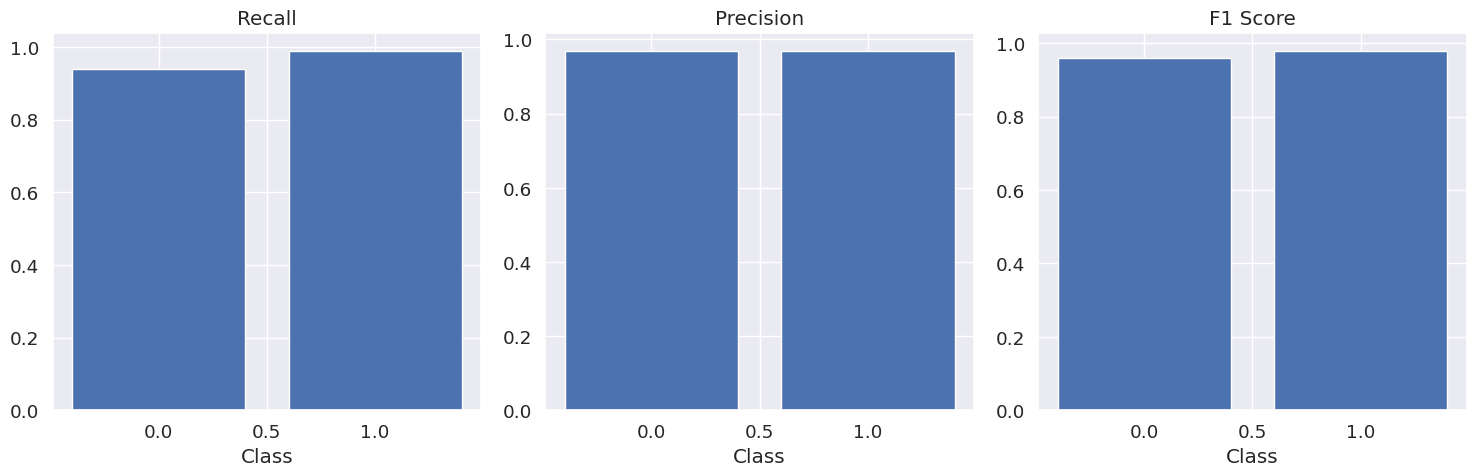

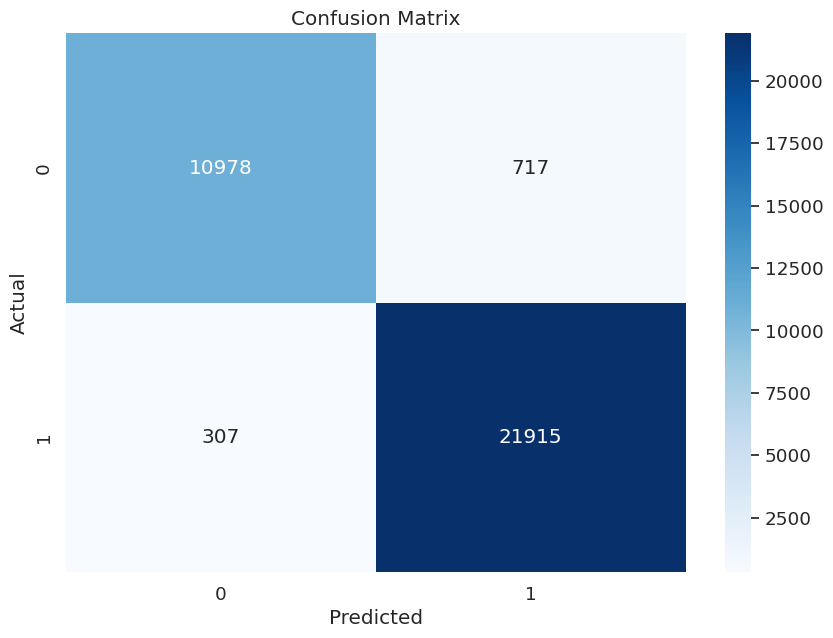

In [25]:
plot_report(report, y_test, predictions)

In [30]:

#print(len(X))
print(y)


[1]


In [16]:
model.save("/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/enzyme_non_enzyme_models/cnn_binary_v2_opt_S70.keras")

# Optimizing Hyperparams
----

In [4]:
def objective(trial):
    # Define hyperparameters to be optimized
    num_units_dense_1 = trial.suggest_int('num_units_dense_1', 32, 512)
    dropout_rate_1 = trial.suggest_float('dropout_rate_1', 0.0, 0.7)
    num_units_dense_2 = trial.suggest_int('num_units_dense_2', 32, 256)
    dropout_rate_2 = trial.suggest_float('dropout_rate_2', 0.0, 0.7)
    num_units_dense_3 = trial.suggest_int('num_units_dense_3', 16, 128)

    # Create the model with the suggested hyperparameters
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=num_units_dense_1, activation='relu', input_shape=(2560,)))
    model.add(tf.keras.layers.Dropout(dropout_rate_1))
    model.add(tf.keras.layers.Dense(units=num_units_dense_2, activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout_rate_2))
    model.add(tf.keras.layers.Dense(units=num_units_dense_3, activation='relu'))
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Split your data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define early stopping callback
    early_stop = tf.keras.callbacks.EarlyStopping(patience=10)

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=25, callbacks=[early_stop], verbose=0)

    # Get the best validation loss
    val_loss = min(history.history['val_loss'])

    return val_loss


In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)


[I 2023-09-29 10:45:22,094] A new study created in memory with name: no-name-82234cf1-939d-4305-a433-845e18b25cb4
2023-09-29 10:45:23.474427: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 926146560 exceeds 10% of free system memory.
[I 2023-09-29 10:53:23,136] Trial 0 finished with value: 0.08489595353603363 and parameters: {'num_units_dense_1': 219, 'dropout_rate_1': 0.2881063416934767, 'num_units_dense_2': 47, 'dropout_rate_2': 0.25664629850376486, 'num_units_dense_3': 100}. Best is trial 0 with value: 0.08489595353603363.
2023-09-29 10:53:23.787126: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 926146560 exceeds 10% of free system memory.
[I 2023-09-29 11:02:14,703] Trial 1 finished with value: 0.08768195658922195 and parameters: {'num_units_dense_1': 308, 'dropout_rate_1': 0.16616023169057298, 'num_units_dense_2': 106, 'dropout_rate_2': 0.5051377426486625, 'num_units_dense_3': 41}. Best is trial 0 with value: 0.08489595353603363.
2023-09-29

# Apply best params
----

In [3]:
best_num_units_dense_1 = 431
best_dropout_rate_1 = 0.5060312811857852
best_num_units_dense_2 = 42
best_dropout_rate_2 = 0.3643652162054985
best_num_units_dense_3 = 69

final_model = tf.keras.models.Sequential()
final_model.add(tf.keras.layers.Dense(units=best_num_units_dense_1, activation='relu', input_shape=(2560,)))
final_model.add(tf.keras.layers.Dropout(best_dropout_rate_1))
final_model.add(tf.keras.layers.Dense(units=best_num_units_dense_2, activation='relu'))
final_model.add(tf.keras.layers.Dropout(best_dropout_rate_2))
final_model.add(tf.keras.layers.Dense(units=best_num_units_dense_3, activation='relu'))
final_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
final_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

# Define early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(patience=10)



In [4]:
final_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, callbacks=[early_stop], verbose=1)

2023-09-29 13:30:14.156099: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 868259840 exceeds 10% of free system memory.


Epoch 1/30
2650/2650 [==============================] - 47s 17ms/step - loss: 0.1831 - accuracy: 0.9321 - val_loss: 0.1363 - val_accuracy: 0.9521
Epoch 2/30
2650/2650 [==============================] - 47s 18ms/step - loss: 0.1392 - accuracy: 0.9508 - val_loss: 0.1231 - val_accuracy: 0.9576
Epoch 3/30
2650/2650 [==============================] - 46s 17ms/step - loss: 0.1248 - accuracy: 0.9570 - val_loss: 0.1214 - val_accuracy: 0.9582
Epoch 4/30
2650/2650 [==============================] - 46s 17ms/step - loss: 0.1159 - accuracy: 0.9604 - val_loss: 0.1116 - val_accuracy: 0.9613
Epoch 5/30
2650/2650 [==============================] - 46s 17ms/step - loss: 0.1076 - accuracy: 0.9632 - val_loss: 0.1112 - val_accuracy: 0.9617
Epoch 6/30
2650/2650 [==============================] - 46s 17ms/step - loss: 0.1018 - accuracy: 0.9651 - val_loss: 0.1035 - val_accuracy: 0.9648
Epoch 7/30
2650/2650 [==============================] - 46s 17ms/step - loss: 0.0980 - accuracy: 0.9664 - val_loss: 0.1090 -

<Figure size 1000x600 with 0 Axes>

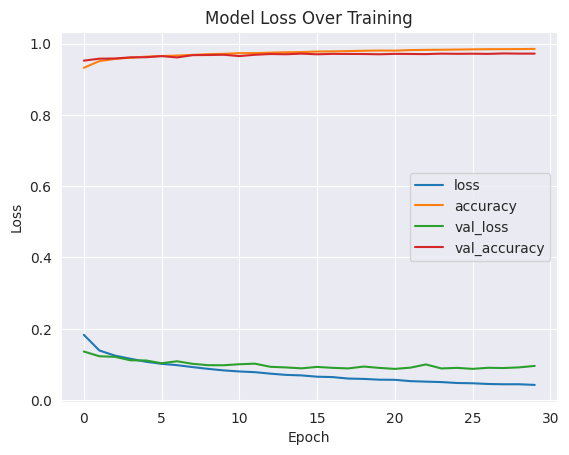

In [6]:
# Plotting loss (loss on train_data) and val_loss (loss on validation_data)
model_loss = pd.DataFrame(final_model.history.history)

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
model_loss.plot()

plt.title('Model Loss Over Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [11]:
predictions = (final_model.predict(X_val) > 0.5).astype(int) # binary classification

counter = 0
for x,y in zip(y_val,predictions):
    if x == y:
        counter+=1
print("Correct predictions: ", counter)
print("Total samples predicted:", len(y_val))


884/884 [==============================] - 2s 3ms/step
Correct predictions:  27467
Total samples predicted: 28264


In [12]:
report = classification_report(y_val, predictions)
print(report)


              precision    recall  f1-score   support

           0       0.98      0.94      0.96      9757
           1       0.97      0.99      0.98     18507

    accuracy                           0.97     28264
   macro avg       0.97      0.96      0.97     28264
weighted avg       0.97      0.97      0.97     28264


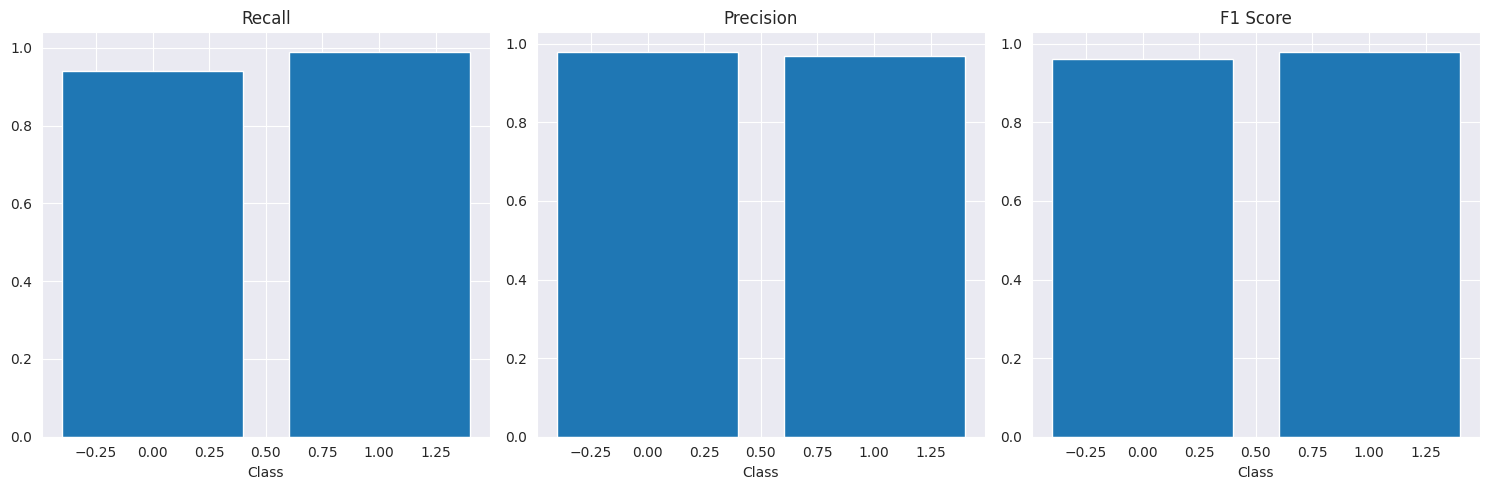

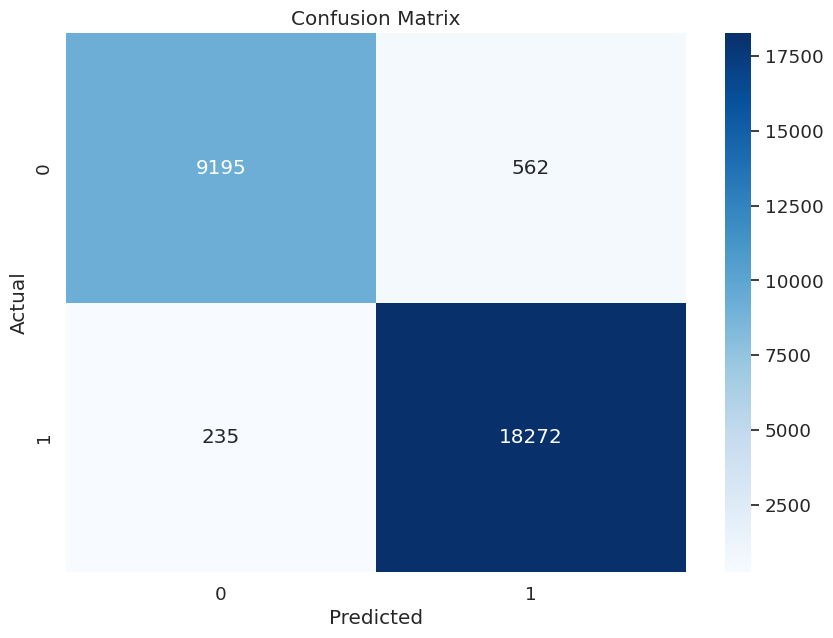

In [14]:
plot_report(report, y_val, predictions)

In [18]:
final_model.save("/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/enzyme_non_enzyme_models/cnn_binary_v2_opt_S70.keras")
